In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image
import os
from PIL import Image
import random
from tensorflow.python.client import device_lib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/376.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/376.9 MB 1.7 MB/s eta 0:03:37
   ---------------------------------------- 0.3/376.9 MB 3.4 MB/s eta 0:01:51
   ---------------------------------------- 0.7/376.9 MB 4.6 MB/s eta 0:01:21
   ---------------------------------------- 1.6/376.9 MB 8.4 MB/s eta 0:00:45
   ---------------------------------------- 3.2/376.9 MB 13.6 MB/s eta 0:00:28
    --------------------------------------- 5.1/376.9 MB 18.1 MB/s eta 0:00:21
    --------------------------------------- 7.2/376.9 MB 21.8 MB/s eta 0:00:17
    --------------------------------------- 9.2/376.9 MB 24.4 MB/s eta 0:00:16
   - -------------------------------------- 11.1/376.9 MB 36.4 MB/s eta 0:00:11
   - -------------------------------------- 13.0/376.9 MB 40.9 MB/s eta 0:00:09
   - -------------------------------------- 14.9/376.9 MB 40.9 MB/s 

In [18]:
#!unzip data.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: data/train/REAL/4500 (10).jpg  
  inflating: data/train/REAL/4500 (2).jpg  
  inflating: data/train/REAL/4500 (3).jpg  
  inflating: data/train/REAL/4500 (4).jpg  
  inflating: data/train/REAL/4500 (5).jpg  
  inflating: data/train/REAL/4500 (6).jpg  
  inflating: data/train/REAL/4500 (7).jpg  
  inflating: data/train/REAL/4500 (8).jpg  
  inflating: data/train/REAL/4500 (9).jpg  
  inflating: data/train/REAL/4500.jpg  
  inflating: data/train/REAL/4501 (10).jpg  
  inflating: data/train/REAL/4501 (2).jpg  
  inflating: data/train/REAL/4501 (3).jpg  
  inflating: data/train/REAL/4501 (4).jpg  
  inflating: data/train/REAL/4501 (5).jpg  
  inflating: data/train/REAL/4501 (6).jpg  
  inflating: data/train/REAL/4501 (7).jpg  
  inflating: data/train/REAL/4501 (8).jpg  
  inflating: data/train/REAL/4501 (9).jpg  
  inflating: data/train/REAL/4501.jpg  
  inflating: data/train/REAL/4502 (10).jpg  
  inflating: dat

In [19]:
dataset_dir = "/data"
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /data


In [52]:
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5242603042104513059
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15337219039664743880
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1


Code was runned using Google Collab

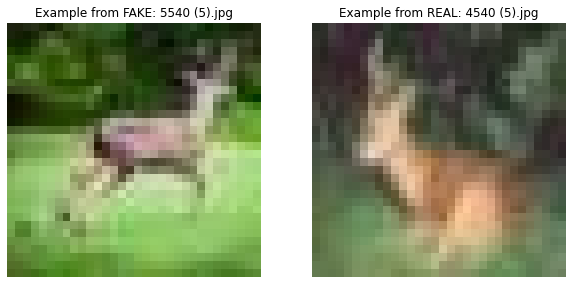

In [13]:
fake_folder = r"C:/Users/hawry/AI_MH_JG/data/train/FAKE"
real_folder = r"C:/Users/hawry/AI_MH_JG/data/train/REAL"

random_index = random.randint(0, min(len(os.listdir(fake_folder)), len(os.listdir(real_folder))) - 1)

fake_image_name = os.listdir(fake_folder)[random_index]
real_image_name = os.listdir(real_folder)[random_index]

fake_image_path = os.path.join(fake_folder, fake_image_name)
real_image_path = os.path.join(real_folder, real_image_name)

fake_image = Image.open(fake_image_path)
real_image = Image.open(real_image_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(fake_image)
axes[0].set_title(f'Example from FAKE: {fake_image_name}')
axes[0].axis('off')

axes[1].imshow(real_image)
axes[1].set_title(f'Example from REAL: {real_image_name}')
axes[1].axis('off')

plt.show()

In [53]:
image_height = 32
image_width = 32
batch_size = 500

train_dataset = tf.keras.utils.image_dataset_from_directory(
    r"C:/Users/hawry/AI_MH_JG/data/train",
    seed=512,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    r"C:/Users/hawry/AI_MH_JG/data/test",
    seed=512,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

print("Training Classes:")
train_class_names = train_dataset.class_names
print(train_class_names)

print("Validation Classes:")
val_class_names = validation_dataset.class_names
print(val_class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Validation Classes:
['FAKE', 'REAL']


In [54]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [56]:
val_true_classes = np.concatenate([y for x, y in validation_dataset], axis=0)
class_names = ['FAKE', 'REAL']
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
efficientnet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(image_height, image_width, 3),
    pooling='max'
)
efficientnet_base_model.trainable = True
inputs = tf.keras.Input(shape=(image_height, image_width, 3))
x = efficientnet_base_model(inputs, training=False)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(
    256,
    kernel_regularizer=regularizers.l2(0.01),
    activity_regularizer=regularizers.l1(0.01),
    bias_regularizer=regularizers.l1(0.01),
    activation='relu'
)(x)
x = Dropout(rate=0.4, seed=512)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
efficientnet_model = tf.keras.Model(inputs, outputs)

efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

efficientnet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                1644

In [58]:
print("Transfer Learning using EfficientNetV2B0")
efficientnet_model_history = efficientnet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=40,
    verbose=1,
    callbacks=[early_stopping_callback]
)

Starting training with Transfer Learning using EfficientNetV2B0...
Epoch 1/40
200/200 [==============================] - 48s 240ms/step - loss: 0.0681 - accuracy: 0.9885 - precision_3: 0.9890 - recall_3: 0.9880 - val_loss: 0.1182 - val_accuracy: 0.9706 - val_precision_3: 0.9624 - val_recall_3: 0.9795
Epoch 2/40
200/200 [==============================] - 48s 238ms/step - loss: 0.0536 - accuracy: 0.9920 - precision_3: 0.9925 - recall_3: 0.9915 - val_loss: 0.1301 - val_accuracy: 0.9728 - val_precision_3: 0.9630 - val_recall_3: 0.9833
Epoch 3/40
200/200 [==============================] - 49s 240ms/step - loss: 0.0443 - accuracy: 0.9939 - precision_3: 0.9943 - recall_3: 0.9935 - val_loss: 0.1296 - val_accuracy: 0.9718 - val_precision_3: 0.9662 - val_recall_3: 0.9779
Epoch 4/40
200/200 [==============================] - 48s 239ms/step - loss: 0.0356 - accuracy: 0.9958 - precision_3: 0.9960 - recall_3: 0.9955 - val_loss: 0.1267 - val_accuracy: 0.9739 - val_precision_3: 0.9780 - val_recall_3: 

40/40 [==============================] - 2s 51ms/step - loss: 0.0945 - accuracy: 0.9748 - precision_3: 0.9796 - recall_3: 0.9699
Validation Loss: 0.0945
Validation Accuracy: 0.9748
Validation Precision: 0.9796
Validation Recall: 0.9699


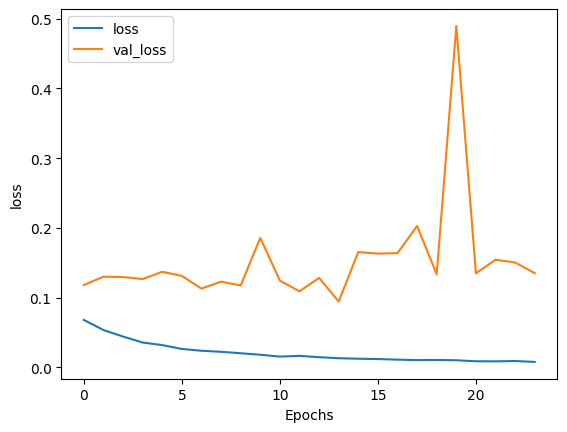

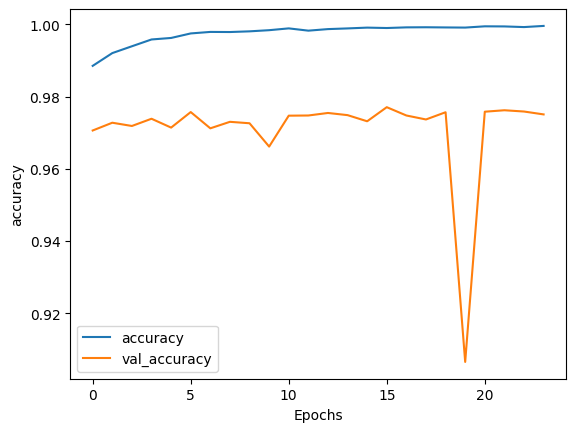

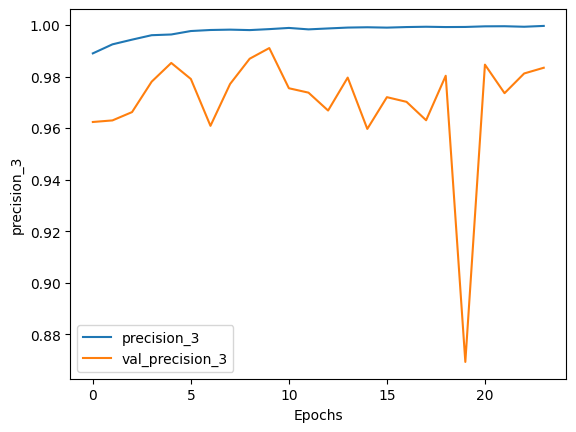

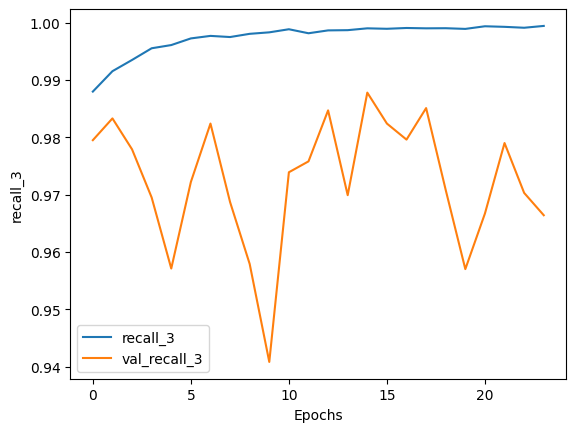

In [59]:
val_loss, val_accuracy, val_precision, val_recall = efficientnet_model.evaluate(validation_dataset)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

plot_metrics(efficientnet_model_history, 'loss')
plot_metrics(efficientnet_model_history, 'accuracy')
plot_metrics(efficientnet_model_history, 'precision_3')
plot_metrics(efficientnet_model_history, 'recall_3')

In [60]:
efficientnet_model.save("efficientnet_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
